数字图像处理 第三次**综合**练习
# 空域图像增强技术

In [347]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy

def show_img(img, title=None):
    plt.figure(dpi=150)
    if title is not None:
        plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap="gray", interpolation="bicubic")
    plt.xticks([])
    plt.yticks([])
    plt.show()

def convert_to_8bit_fully(img):
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

def cut_to_8bit(img):
    res = copy.copy(img)
    res[res<0] = 0
    res[res>255] = 255
    return res.astype(np.uint8)

def show_img_with_neg(img, title=None):
    show_img(convert_to_8bit_fully(img), title)


def show_imgs(img_and_title):
    plt.figure(dpi=150)
    sz = len(img_and_title)
    for i in range(0, sz):
        plt.subplot(1, sz, i+1)
        img = img_and_title[i][0]
        title = img_and_title[i][1]
        if title is not None:
            plt.title(title)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap="gray", interpolation="bicubic")
        plt.xticks([])
        plt.yticks([])
    plt.show()

def show_hist(img):
    plt.hist(img)
    plt.show()

裁剪原图像,转换为灰度图$A$

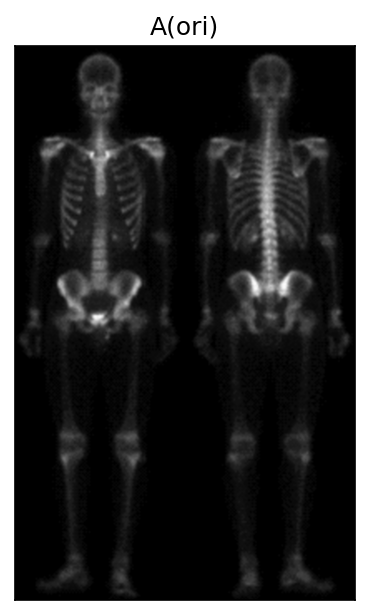

In [348]:
img = cv2.imread("guge.png")
# 裁剪掉原图奇怪的边框,以免干扰后续
img = img[5:-1,10:-1]
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_img(img_gray, "A(ori)")

对原图进行Sobel运算得到梯度,取绝对值并与原图像相加得到$D$,再高斯平滑得到$E$

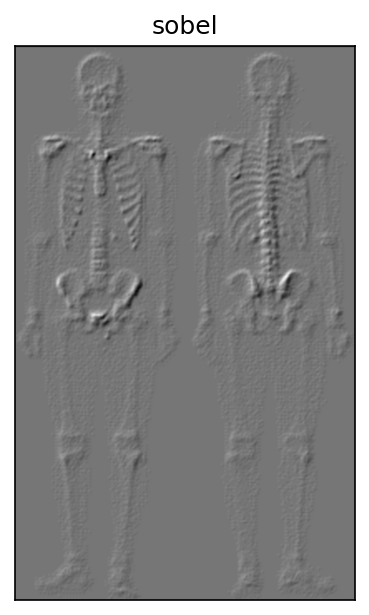

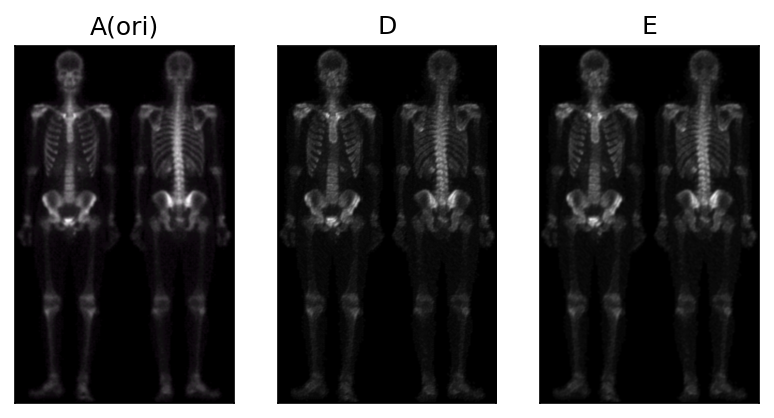

In [349]:
# Sobel 算子
x = cv2.Sobel(img_gray, cv2.CV_16S, 1, 0)
y = cv2.Sobel(img_gray, cv2.CV_16S, 0, 1)
# plt.hist(x)
# plt.show()
# plt.hist(y)
# plt.show()
sobel = 0.5*x+0.5*y
show_img_with_neg(sobel, "sobel")
sobel = np.abs(sobel)
D = sobel + img_gray
E = cv2.GaussianBlur(D,(3,3),0)

show_imgs([[img, "A(ori)"], [convert_to_8bit_fully(D), "D"], [convert_to_8bit_fully(E), "E"]])

使用Laplacian求A的二阶导数,得到$B$,$A$相减$B$得到$C$

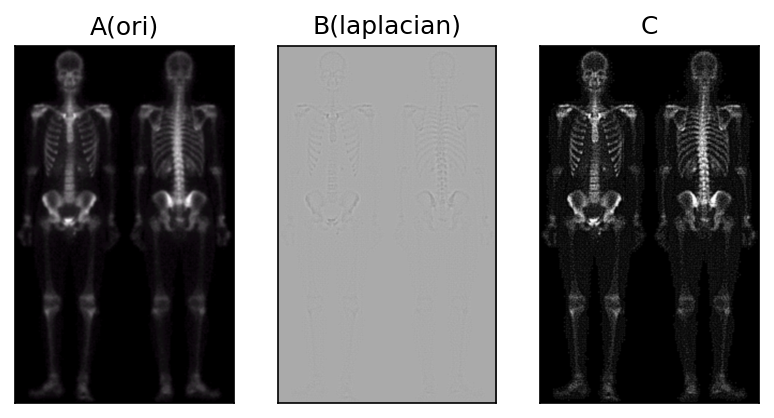

In [350]:
# Laplacian
laplacian = cv2.Laplacian(img_gray, cv2.CV_16S, ksize = 3)
ori_dec_laplacian = img_gray - laplacian
# C = np.abs(ori_dec_laplacian)
C = cut_to_8bit(ori_dec_laplacian)
# show_hist(ori_dec_laplacian)
# show_hist(C)
show_imgs([[img, "A(ori)"], [convert_to_8bit_fully(laplacian), "B(laplacian)"], [C, "C"]])

将$C$与$E$相乘得到$F$,在与原图像相加得到$G$

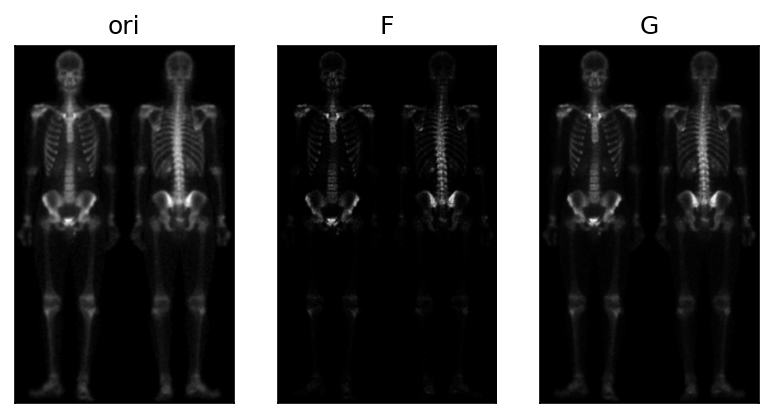

In [351]:
F = convert_to_8bit_fully(np.multiply(C, E))
G = convert_to_8bit_fully(img_gray.astype(np.uint16) + F.astype(np.uint16))
# show_hist(F)
# show_hist(img_gray)
show_imgs([[img_gray, "ori"], [F, "F"],[G, "G"]])

对$G$做伽玛变换,指数增强得到$H$

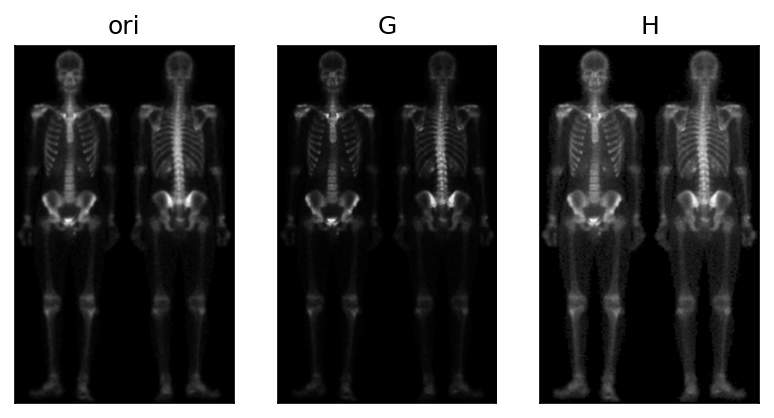

In [352]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

gama = adjust_gamma(G, 1.75)
show_imgs([[img_gray, "ori"], [G, "G"],[gama, "H"]])

完成处理,处理前后对比如下:

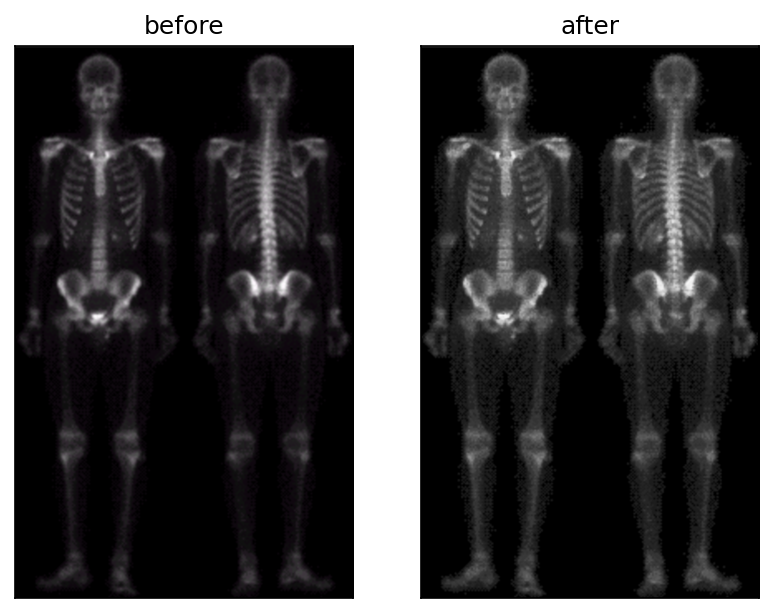

In [353]:
show_imgs([[img, "before"], [gama, "after"]])